In [1]:
%matplotlib inline
import lightkurve as lk
from lightkurve_ext import download_lightcurvefiles, of_sector, of_sectors
import lightkurve_ext as lke
import tic_plot as tplt

import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
# TIC can be found from PHT Subject metadata

# tic = 55525572 # 1st Planet Candidate from PHT
tic = 286923464 # TOI 1271.01, Known planet HD118203 b around a sub giant (unusual) TESS observations helped to improve stellar model  https://astrobites.org/2019/12/26/tess-reveals-hd118203-b-transits-after-13-years/
use_cache = 'yes'


# Load the light_curves into collection
lcf_coll = download_lightcurvefiles(f"TIC{tic}", mission='TESS', download_dir='./data', use_cache=use_cache)
print(f"TIC {tic} \t#sectors: {len(lcf_coll)}")

# Other examples:
# Kepler-11, a known multi-planet system https://astrobites.org/2011/02/03/dip-detection-in-the-kepler-data/
# also TIC 169175503
# lcf_coll = lke.download_lightcurvefiles(f"Kepler11", mission='Kepler', download_dir='./data')
#
# KIC9832227 : a known contact binary
# lcf_coll = lke.download_lightcurvefiles(f"KIC9832227", mission='Kepler', download_dir='./data')
#
# KIC11904151: Kepler 10b, 
# processing tips from
#  https://github.com/barentsen/kepler-athenaeum-tutorial/blob/master/how-to-find-a-planet-tutorial.ipynb
# lcf_coll = lke.download_lightcurvefiles(f"KIC11904151", mission='Kepler', download_dir='./data')
#
# WASP-47, with multiple known planets. Mass deduced by transit time variations https://astrobites.org/2015/10/20/wasp-47-a-hot-jupiter-with-friends/
# lcf_coll = lke.download_lightcurvefiles(f"EPIC206103150", mission='K2', download_dir='./data') 

# a beep to remind the users that the data has been downloaded
from IPython.display import Audio
display(Audio(url='https://upload.wikimedia.org/wikipedia/commons/f/fb/NEC_PC-9801VX_ITF_beep_sound.ogg', autoplay=True, embed=True))


TIC 286923464 	#sectors: 3


In [3]:
# Show MAST search results
# search_res = lk.search.search_lightcurvefile(f"TIC{tic}", mission='TESS')
# search_res.table

Sectors: [15, 16, 22] (3)
Observation period range / data range:
  Sector 15: 1711.361442715728 - 1737.399999818419
   (cam 4)   1711.362137026201 - 1737.4062499191018
  Sector 16: 1738.648606818424 - 1763.316949581586
   (cam 4)   1738.6493011458838 - 1763.316255237362
  Sector 22: 1899.321399028552 - 1926.496548627605
   (cam 3)   1899.309593171361 - 1926.495854305018


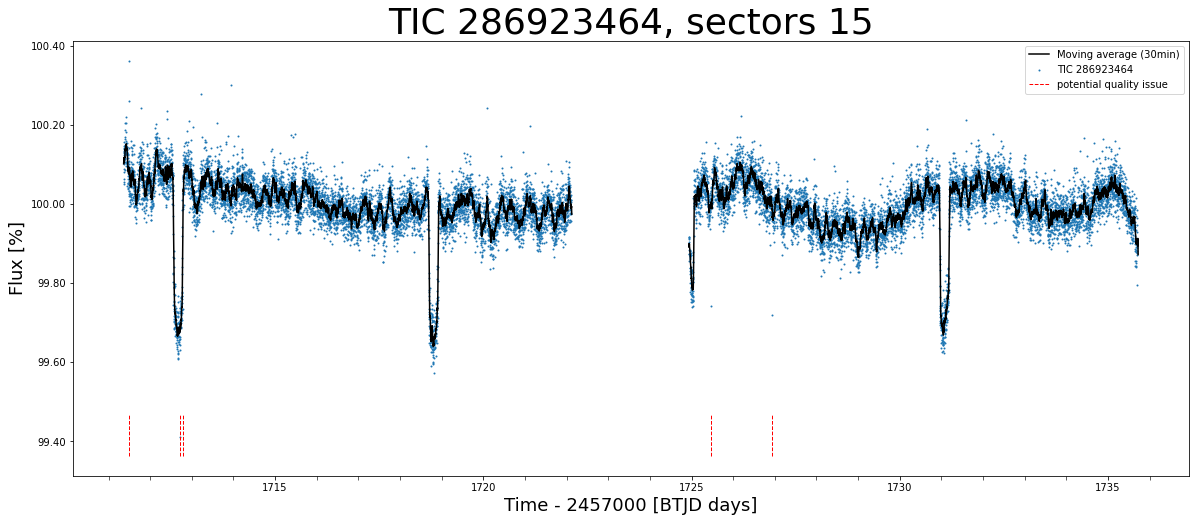

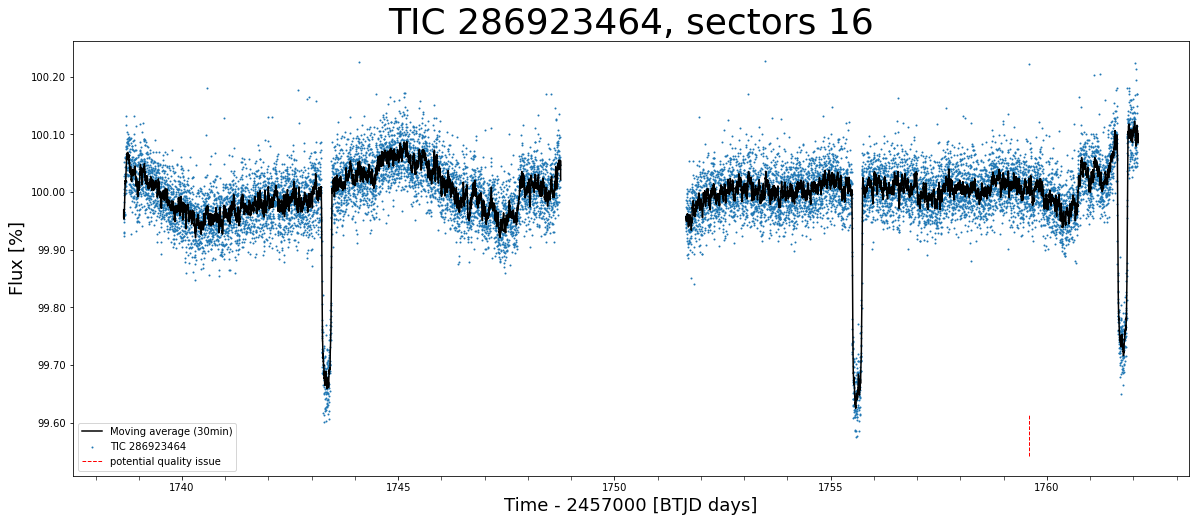

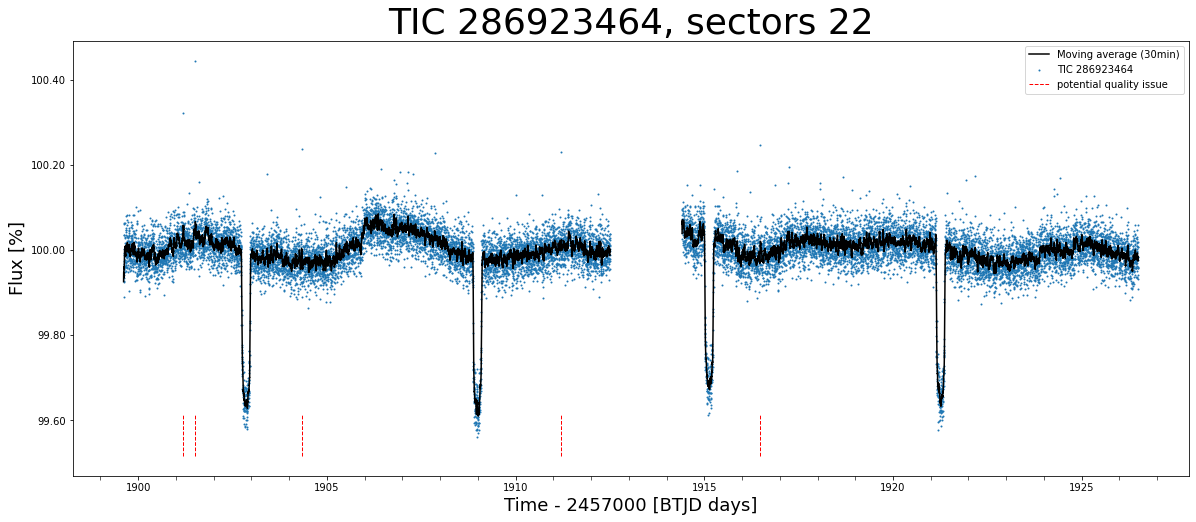

In [4]:
# plot all the data
tplt.print_data_range(lcf_coll)

axs = tplt.plot_all(
              lcf_coll  # or only plot some sectors of_sectors(lcf_coll, 15, 16) 
              , moving_avg_window='30min' # None # '20min' # '30min'
#                   , lc_tweak_fn=lambda lc: lc.remove_outliers(sigma=3) 
              , ax_fn=lambda: plt.figure(figsize=(20,8)).gca()
#                   , use_relative_time=True
#                   , mark_quality_issues=False
              , ax_tweak_fn=lambda ax: [
#                                             ax.set_ylim(99.5, 100.5)
#                                             , ax.set_xlim(2000, 2006)
                                       ]
             )


Transits, zoomed-in


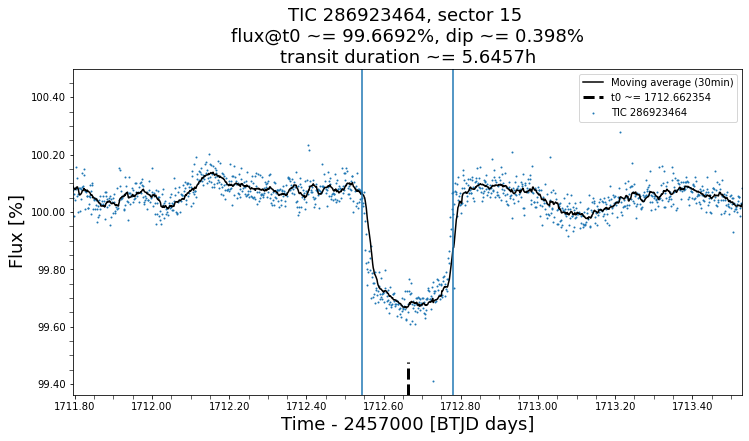

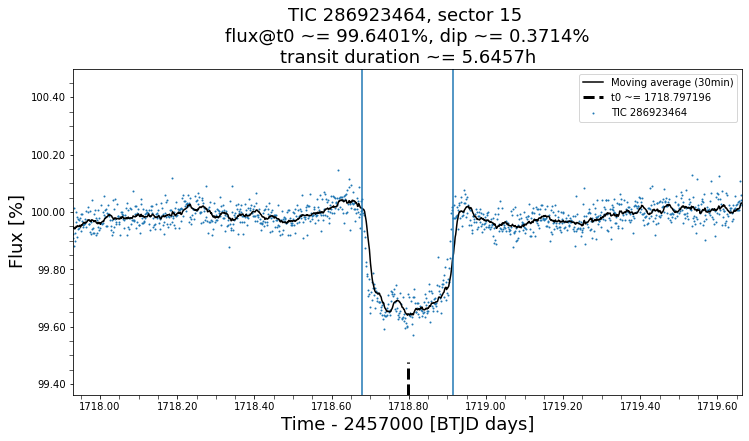

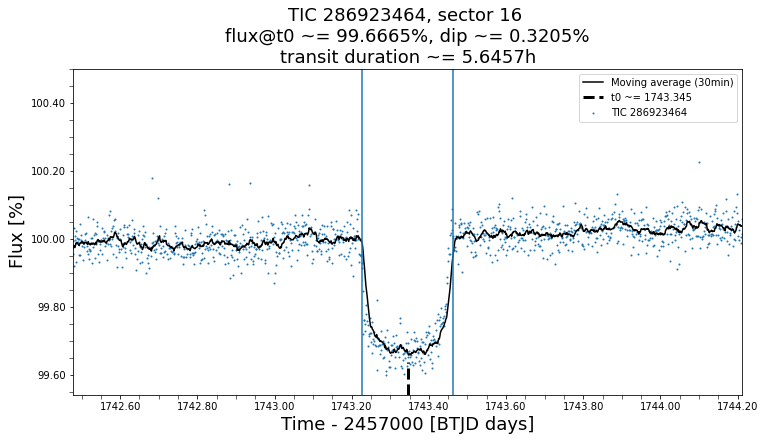

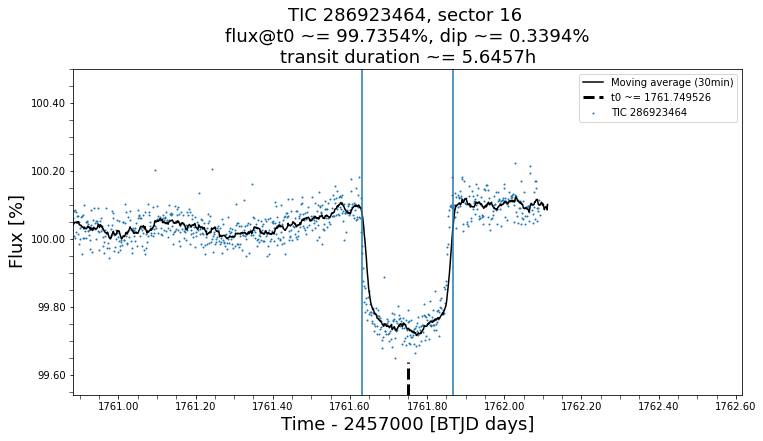

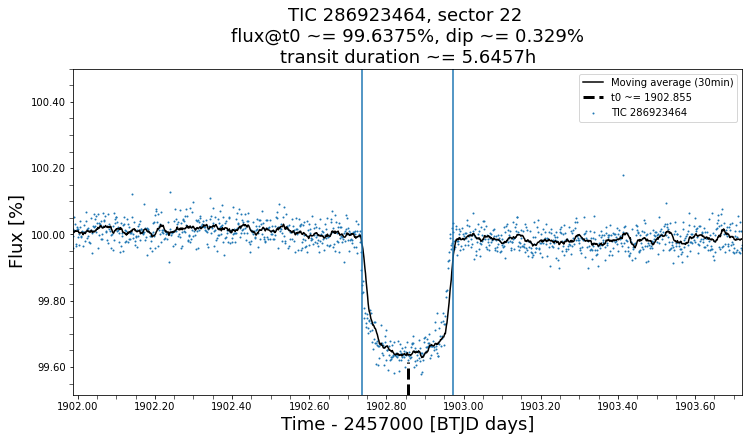

In [5]:
# Plots, zoomed-in around selected dips / transits

transit_specs = [
    dict(sector=15
         , t0 = 1712.662354 # from TOI 1271.01
         , steps_to_show = [0, 1])
    ,
    dict(sector=16
        , t0=1743.345
        , steps_to_show = [0, 3])
    ,
    dict(sector=22
        , t0=1902.855)
]
transit_defaults = dict(duration_hr = 5.6457, period = 6.134842)
figsize = (12,6) # (15, 9) 
axs = tplt.plot_transits(lcf_coll, transit_specs, transit_defaults
                         , ax_fn=lambda: plt.figure(figsize=figsize).gca()
                         , t0mark_ymax=0.1
#                          , lc_tweak_fn=lambda lc: lc.remove_nans().bin(binsize=7)
                         , moving_avg_window='30min' # '10min' # None, '20min' #  '30min'
#                          , set_title=False                   
                        , ax_tweak_fn=lambda ax: [
                            ax.set_ylim(None, 100.5)
#                        , ax.axvline(2002.8274702863073, c='r', linestyle='--')
                        ]
                        )
print('Transits, zoomed-in')


In [6]:
# Understand the quality issues marked by dotted red line in plot_all()
for lcf in lcf_coll:
    qual_time, qual_flags = lke.list_times_w_quality_issues(lcf.PDCSAP_FLUX)
    print(f"Sector {lcf.get_header()['SECTOR']}: ", [(tplt.as_4decimal(t), lk.utils.TessQualityFlags.decode(f)) for t, f in zip(qual_time, qual_flags)])


Sector 15:  [(1711.501, ['Impulsive outlier']), (1712.7288, ['Impulsive outlier']), (1712.7815, ['Impulsive outlier']), (1725.466, ['Impulsive outlier']), (1726.941, ['Impulsive outlier'])]
Sector 16:  [(1759.5898, ['Impulsive outlier'])]
Sector 22:  [(1901.1874, ['Impulsive outlier']), (1901.5124, ['Impulsive outlier']), (1904.3277, ['Impulsive outlier']), (1911.2, ['Impulsive outlier']), (1916.4792, ['Impulsive outlier'])]


In [7]:
# List transit times for other usages, e.g., inputs to LATTE
if True:
    t0 = transit_specs[0]['t0']
    period = transit_specs[0].get('period', transit_defaults['period'])    
    print(lke.list_transit_times(t0, period, range(0,10), return_string=True))
    print(lke.get_transit_times_in_lc(
        lcf_coll[0].PDCSAP_FLUX,                                       
        t0, period,
        return_string=True
    ))


1712.662354,1718.797196,1724.9320380000001,1731.06688,1737.201722,1743.336564,1749.4714060000001,1755.606248,1761.74109,1767.8759320000001
1712.662354,1718.797196,1731.06688,1737.201722


Num of observations to be flattened:  8874


Text(0.5, 1.0, 'Compare the extracted trends')

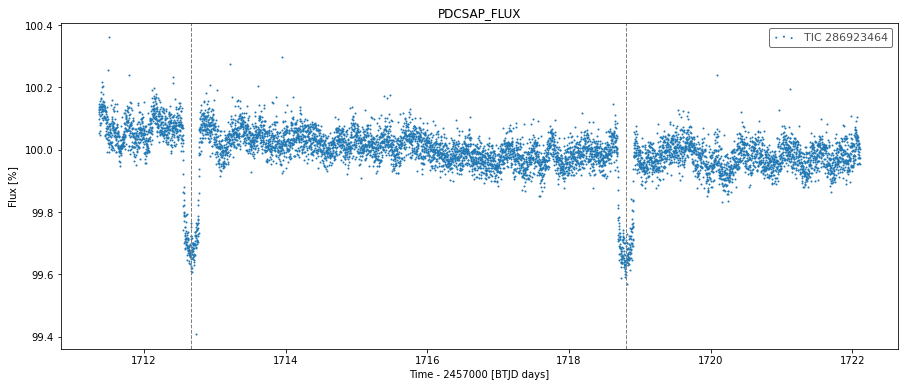

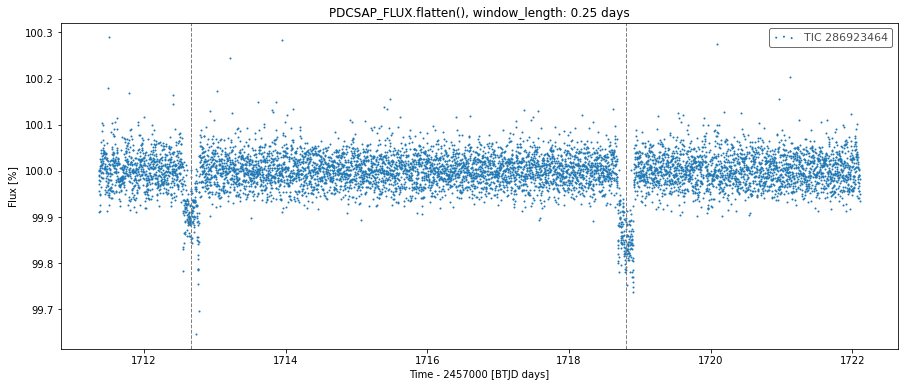

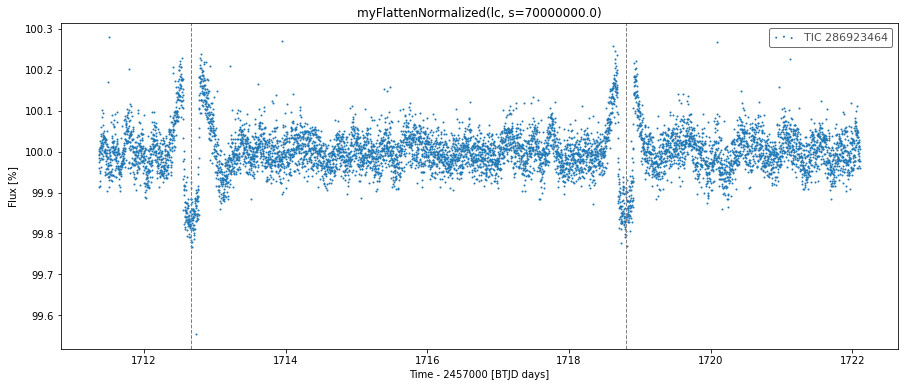

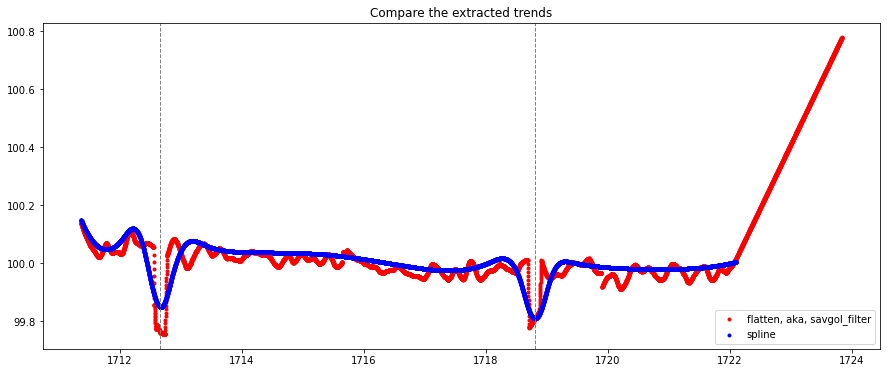

In [8]:
# detrend using 
# 1. built-in  flatten (with savgol filter), and 
# 2. spline-based flatten

def myFig():
    return plt.figure(figsize=(15, 6))

lcf = lcf_coll[0]
lc = lcf.PDCSAP_FLUX

t0 = transit_specs[0]['t0']
period = transit_specs[0].get('period', transit_defaults['period'])    

lc = lc[0:math.floor(len(lc)/2)] # optional zoom in to better see the details, or speed up the process
dips = lke.get_transit_times_in_lc(lc, t0, period)

print('Num of observations to be flattened: ', len(lc))

# lcf.SAP_FLUX.normalize(unit='percent').scatter(ax=myFig().gca())
# plt.title('SAP_FLUX')

ax = lc.normalize(unit='percent').scatter(ax=myFig().gca())
tplt.markTimes(ax, dips)
plt.title('PDCSAP_FLUX')

# window_length: chosen to be slightly larger than a transit period, flattening out the mini flucutations.
window_length_days = 6/24
lc_flattened, lc_trend = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days), return_trend=True)
ax = lc_flattened.normalize(unit='percent').scatter(ax=myFig().gca())
tplt.markTimes(ax, dips)
plt.title(f'PDCSAP_FLUX.flatten(), window_length: {window_length_days} days')


# the smaller the s (smoothing factor), the more flattened the result, i.e.,
# more variation is extracted as long-term trend
# s=1e7 fits okay for this subject after some trial and error
# comparing it with savgol_filter used by flattened(), it does not handle sudden dips in transits as well, 
# spline seems to either sawllow the dips in the trend, or smooth insufficient (leaving too much variation in the detrended)
spline_s = 7e7
lc_myFlattened, lc_myTrend = lke.flatten_with_spline_normalized(lc, return_trend=True, k=3, s=spline_s)
ax = lc_myFlattened.scatter(ax=myFig().gca())
tplt.markTimes(ax, dips)
plt.title(f'myFlattenNormalized(lc, s={spline_s})')

# Compare the trends from flattened vs spline
fig = myFig()
ax = fig.gca()
ax.scatter(lc_trend.time, lc_trend.normalize(unit='percent').flux, c='r', marker='.', label="flatten, aka, savgol_filter")
ax.scatter(lc_myTrend.time, lc_myTrend.normalize(unit='percent').flux, c='b', marker='.', label='spline')
tplt.markTimes(ax, dips)
fig.gca().legend()
plt.title('Compare the extracted trends')



C:\pkg\_winNonPortables\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:702: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)


lc_folded time scale:  None
lc_folded phase:  [-0.49998485 -0.49994808 -0.49986625 ...  0.49997018  0.49997448
  0.49998239]
lc_folded time scale:  None
lc_folded phase:  [-0.49998485 -0.49994808 -0.49986625 ...  0.49997018  0.49997448
  0.49998239]


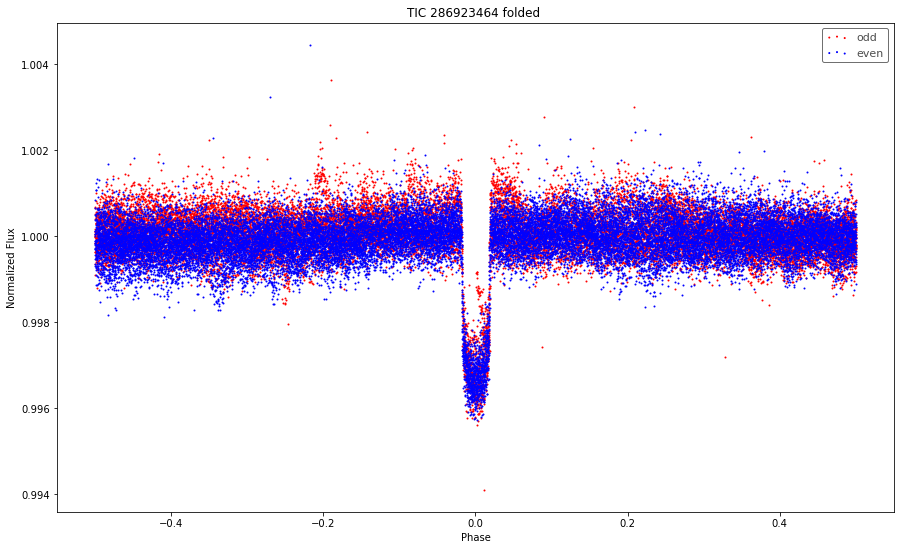

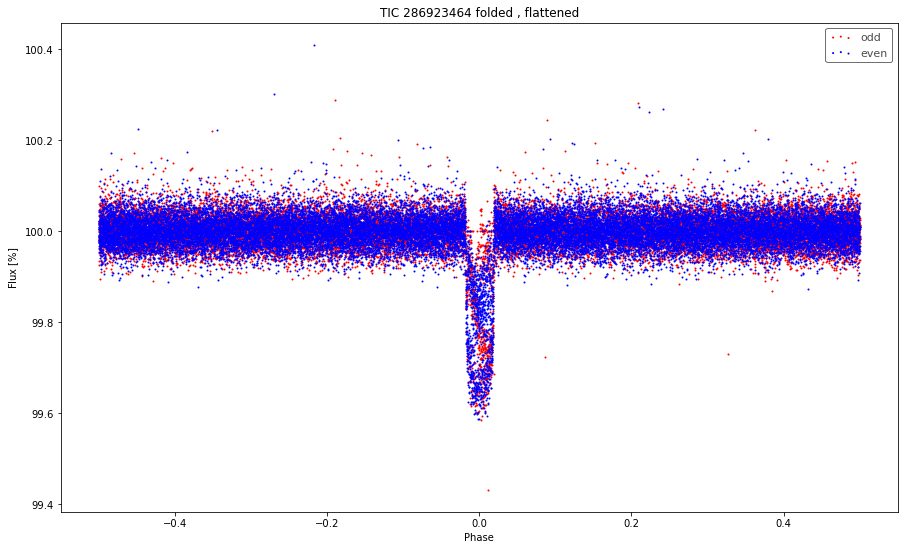

In [9]:
# Fold lightcurves

# optionally use only specific sectors
lc = of_sectors(lcf_coll)\
    .PDCSAP_FLUX.stitch()
lc_flattened = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days))\
                 .normalize(unit='percent')

t0 = transit_specs[0]['t0']
period = transit_specs[0].get('period', transit_defaults['period'])    


def fold_and_plot(lc, title_extra=''): 
    lc_folded = lc.fold(t0=t0, period=period)

    ax=plt.figure(figsize=(15, 9)).gca()
    lc_folded[lc_folded.odd_mask].scatter(ax=ax, c='r', label='odd')
    lc_folded[lc_folded.even_mask].scatter(ax=ax, c='b', label='even')
    plt.title(f'{lc.label} folded {title_extra}')
    print('lc_folded time scale: ', lc_folded.time_scale)
    print('lc_folded phase: ', lc_folded.phase)

fold_and_plot(lc)
fold_and_plot(lc_flattened, ', flattened')



Text(0.5, 1.0, 'TIC 286923464')

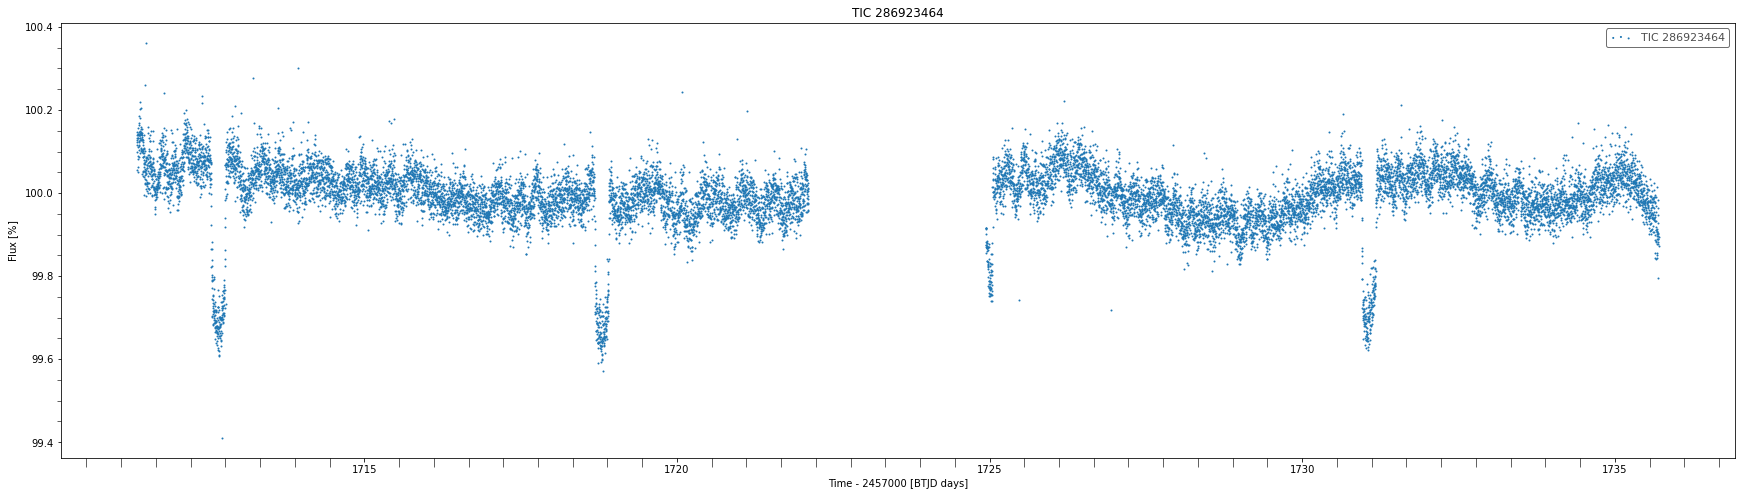

In [10]:
# custom plots, typical for stiching lightcurves from multiple sectors

# lcf_coll.plot()

lc = None
for lcf in lcf_coll[0:1] : # of_sectors(lcf_coll, 23, 24, 25, 26):
    if lc is None:
        lc = lcf.PDCSAP_FLUX
    else:
        lc = lc.append(lcf.PDCSAP_FLUX)
lc = lc.normalize(unit='percent')


# lc = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days))
ax = plt.figure(figsize=(30, 8)).gca()
lc.scatter(ax=ax)
# ax.set_ylim(98.5, 102)
ax.xaxis.set_minor_locator(AutoMinorLocator(9))
ax.tick_params(axis='x', which='minor', length=9)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='y', which='minor', length=4)
ax.set_title(lc.label)


Num of observations: 34468
Observation elapsed time: 51.9541182111609


BLS
lightkurve.Periodogram properties:
        Attribute            Description     Units
------------------------- ------------------ -----
                 targetid          286923464      
             default_view             period      
                    label      TIC 286923464      
                time_unit                day      
       depth_at_max_power             0.0024      
    duration_at_max_power               0.25     d
   frequency_at_max_power             0.1632 1 / d
                max_power         41960.0489      
      period_at_max_power             6.1283     d
transit_time_at_max_power          1712.6871      
                    depth      array (4035,)      
                 duration      array (4035,)     d
                     flux     array (29940,)      
                frequency      array (4035,) 1 / d
                   period      array (4035,)     d
                    power      array (4035,)      
                      snr      array (4035,

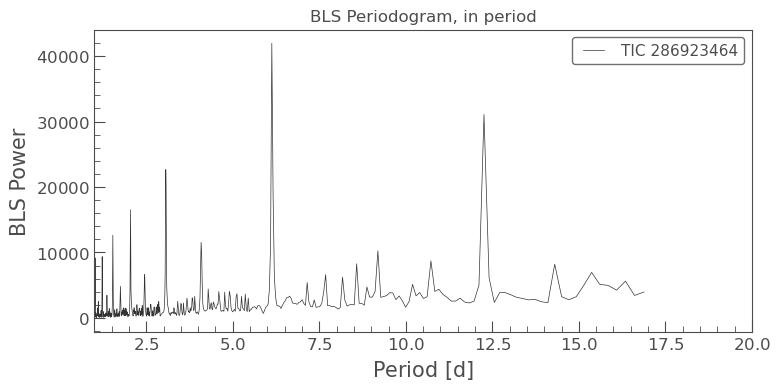

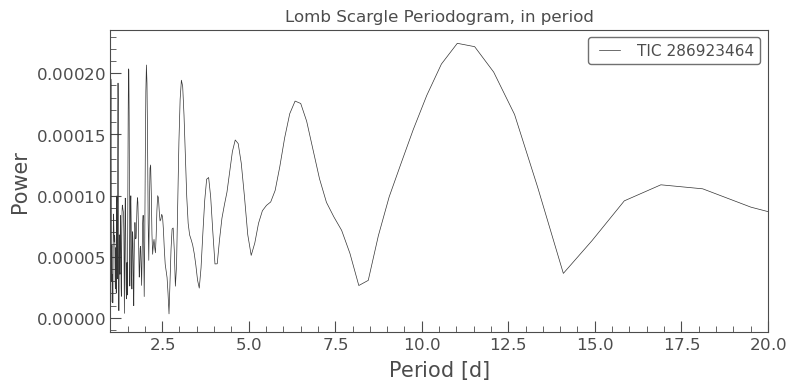

In [13]:
# run BLS against all / subset of data 

lc = of_sectors(lcf_coll, 15, 16).PDCSAP_FLUX.stitch()
# lc = lcf_coll.PDCSAP_FLUX.stitch()

print('Num of observations:', len(lc))
print('Observation elapsed time:', lc.time.max()  - lc.time.min())

# use the interactive transit period detection
#   caveat: un-sure if combining observations over time make sense for the algorithm
lc.interact_bls()

# if False: 
if True: 
    x_min = 1
    x_max = 20
    # Box Least Square assumes U-shaped transit model (rapid dips)
    pdg_bls = lc.remove_nans().to_periodogram(method='bls')
    print('BLS')
    pdg_bls.show_properties()
    ax = pdg_bls.plot()
    ax.set_title('BLS Periodogram, in period')
    ax.set_xlim(x_min, x_max)

    # Lomb Scargle better for general vairable curves with sin-like shape (gradual flucutation)
    pdg_ls = lc.remove_nans().to_periodogram(method='lombscargle')
    print('Lomb Scargle')
    pdg_ls.show_properties()
    ax = pdg_ls.plot(view='period')
    ax.set_title('Lomb Scargle Periodogram, in period')    
    ax.set_xlim(x_min, x_max)
    
    

In [ ]:
# check to see if there is any known solar system objects around a transit
lc = of_sector(lcf_coll, 26).PDCSAP_FLUX

t_epoch = 2016.1330800000578
duration_hr = 21.3918
surround_time = 1

duration = duration_hr / 24
t0 = t_epoch

df_sso = lc.query_solar_system_objects(cadence_mask=(lc.time >= t0 - (duration + surround_time)/2) & (lc.time <= t0 + (duration + surround_time)/2))

print(df_sso)

from IPython.display import Audio
display(Audio(url='https://upload.wikimedia.org/wikipedia/commons/f/fb/NEC_PC-9801VX_ITF_beep_sound.ogg', autoplay=True, embed=True))


In [ ]:
# useful for visualizing transit time variation

lc = lcf_coll[0].PDCSAP_FLUX.normalize(unit='percent')

# from the https://exo.mast.stsci.edu/exomast_planet.html?planet=EPIC206103150b
period=4.1591289
t0=57007.4321 + 2400000.5 - 2454833 # convert from MJD to BKJD

# from the https://exo.mast.stsci.edu/exomast_planet.html?planet=EPIC206103150d
# period=9.03077
# t0= 57005.8693 + 2400000.5 - 2454833 # convert from MJD to BKJD
      
lc_folded = lc.fold(period=period, t0=t0)

print("t0:", t0)
lc_folded.scatter(ax=plt.figure(figsize=(15, 5)).gca())

lc.plot_river(period=period, t0=t0, ax=plt.figure(figsize=(15, 5)).gca()
             , minimum_phase=-0.015, maximum_phase=+0.015, method='median')
